# Week 1: design and data representation
This week's tutorial/assignment will be about the basics of pattern analysis. It's very important that you understand the discussed concepts, as they form the basis of the rest of the course's tutorials/assignments. Additionally, we'll discuss some new programming concepts (mostly object-oriented programming), as this will become more and more important as you're going to learn how to program everything yourself in Python. 

Specifically, at the end of this tutorial, you will be able to:

* Understand the major differences between within- and between-subject first-level designs for pattern estimation;
* Understand the concept of object-oriented programming and know how to construct classes for neuroimaging-purposes;
* Implement functionality to load, organize, and efficiently represent voxel pattern for pattern analyses;
* Implement simple preprocessing functions/methods for voxel patterns;



## 1. Designs for pattern analyses
There are many ways in which you can categorize different types of pattern analyses (a topic which you'll work on in Thursdays's seminar), but one of the most basic categorizations is in terms of whether analyses are **within-subject** or **between-subject**. The major distinction revolves around whether you want to investigate an (experimental) factor that varies or is manipulated within subjects or that varies across subjects (i.e. individual differences or experimental between-subject designs).

Importantly, both types of analyses differ in what is regarded as an *instance of a pattern*:
- in within-subject analyses, *each instance of your feature-of-interest represents one pattern*;
- in between-subject analyses, *each subject represents one pattern*.

In part 3 of this tutorial (Data representation), we'll discuss how these patterns in within- and between-subject analyses are typically represented. This part (Designs for pattern analyses) will focus on how to extract patterns from fMRI data.

As explained in the lecture, there are three ways to extract patterns from fMRI data: 

1. extract activity at a certain timepoint (e.g. 3 TRs after stimulus presentation);
2. extract the *average* activity within a time-range (e.g. 2-4 TRs after stimulus presentation);
3. extract patterns of $\beta$-estimates by fitting a HRF per trial using the GLM you're familiar with; 

In the first part of this tutorial, we'll focus on method 3 (as this has been shown to yield the most stable pattern estimates). We will show you how the design matrices for the GLM in method 3 look like for both (single-trial) within-subject analyses and between-subject analyses. 

### 1.2. Within-subject designs
Often, "trials" (i.e. instances of your feature-of-interest) in within-subject designs are modelled as separate regressors in a first-level analysis. In other words, you model each trial as a separate (*single!*) HRF-response. Below, we included an image of a single-trial design (of the hypothetical faces vs. houses experiment) as created in FSL:<img src="single_trial_design.png" alt="Drawing" heigth="100" width="400">

As you can see, each trial (either a face or a house) gets it's own regressor. Then, as depicted below the design matrix, a contrast-against-baseline is created for each regressor (trial). After you run a first-level analysis using this design, you'll have whole-brain maps containing statistics values (beta-values, t-values, or z-values) for each trial that represent the trial's estimated (whole-brain) pattern. Usually, t- or z-values are used instead of betas.  

**Importantly, this design thus specifies that each "trial" represents a sample with its own pattern (voxels).**

Before you go on, make sure you understand this image! This image represents basically all you need to understand about single-trial designs. 

#### Implement your own single-trial design
In this section, you'll create your own single-trial matrix corresponding to a (real) working memory experiment (similar to the one described in Monday's lecture). In this experiment, one condition ("ACTIVE") subjects had to remember a configuration of bars and after a retention period had to respond whether one of the bars has changed in the test-image or not. In the other condition ("PASSIVE") they just watched a blank screen and had to respond with a random answer. The experiment is depicted schematically below:

![test](WM_example.png) 

In total, subjects performed 40 trials, of which 32 were of the "ACTIVE" condition and 8 were of the "PASSIVE" condition. In the following section, we'll generate a single-trial design that aims to estimate the pattern for each trial.

Below, we'll load the onsets (and durations and conditions).

In [1]:
# First some imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
# Numpy array with onsets (column 1), durations (column 2), and conditions (column 3)
# N.B.: condition 0 = passive, condition 1 = active
onsets = np.loadtxt('onsets.csv').astype(int)
print("Onset Duration Condition")
print(onsets)

Onset Duration Condition
[[  8   6   1]
 [ 20   6   1]
 [ 26   6   1]
 [ 36   6   0]
 [ 42   6   1]
 [ 52   6   1]
 [ 60   6   1]
 [ 66   6   1]
 [ 72   6   1]
 [ 78   6   1]
 [ 86   6   1]
 [ 92   6   1]
 [100   6   1]
 [106   6   0]
 [112   6   1]
 [118   6   1]
 [126   6   0]
 [134   6   1]
 [140   6   1]
 [150   6   1]
 [156   6   0]
 [162   6   0]
 [172   6   1]
 [180   6   1]
 [188   6   1]
 [194   6   1]
 [204   6   0]
 [210   6   1]
 [216   6   1]
 [222   6   1]
 [228   6   1]
 [238   6   1]
 [244   6   1]
 [252   6   1]
 [258   6   1]
 [264   6   1]
 [272   6   0]
 [280   6   0]
 [296   6   1]
 [302   6   1]]


<div class='alert alert-warning'>
**ToDo**: Practice your numpy-skills! How would you calculate how many active-trials and how many passive-trials there were? 
</div>

In [3]:
# Implement your ToDo here
n_active = np.sum(onsets[:, 2] == 1)
print("Number of active trials: %i" % n_active)

n_passive = np.sum(onsets[:, 2] == 0)
print("Number of passive trials: %i" % n_passive)

Number of active trials: 32
Number of passive trials: 8


Remember, the onsets (and duration) are here defined in seconds (not TRs). Let's assume that the fMRI-run has a TR of 2. Now, we can convert (very easily!) the onsets/durations-in-seconds to onsets/durations-in-TRs.

<div class='alert alert-warning'>
**ToDo**: Convert the onsets and durations from seconds to TRs.
</div>

In [4]:
# The most straightfoward implementation would be:
onsets[:, :2] = onsets[:, :2] / 2 

Now, as you might remember, for each regressor we need to create a regressor of zeros and ones, in which the ones represent the moments in which the particular trial was presented. Remember, if a stimulus lasted 6 seconds (i.e. 3 TRs), make sure that your regressor also models your event for this duration! 

So, for example, if you have a (hypothetical) run with a duration of 15 TRs, and you show a stimulus at TR=3 for the duration of 3 TRs (i.e. 6 seconds), then you'd code your regressor as:

`[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

<div class='alert alert-warning'>
**ToDo**: Below, we initialized a stimulus vector (`stim_vec`) of shape=[162, 40], i.e. timepoints x trials (this run was 162 TRs long), with zeros. Each of the 40 rows represents one trial. Loop over the colums of the `stim_vec` matrix and fill the times at onset till the onset + 2 TRs with ones. Remember, the first index in Python is zero (not 1!).
</div>

In [5]:
# This was a bit trickier than I though ...
stim_vec = np.zeros((162, 40))

for i in range(stim_vec.shape[1]):
    
    # Extract onset of trial i
    this_onset = onsets[i, 0]
    # Set onset + 2 TRs to 1
    stim_vec[[this_onset - 1, this_onset, this_onset + 1], i] = 1

Now, we only need to convolve an HRF with the stimulus-vectors and we'll have a complete single-trial design! Don't worry, we do this for you. We'll also plot it to see how it looks.

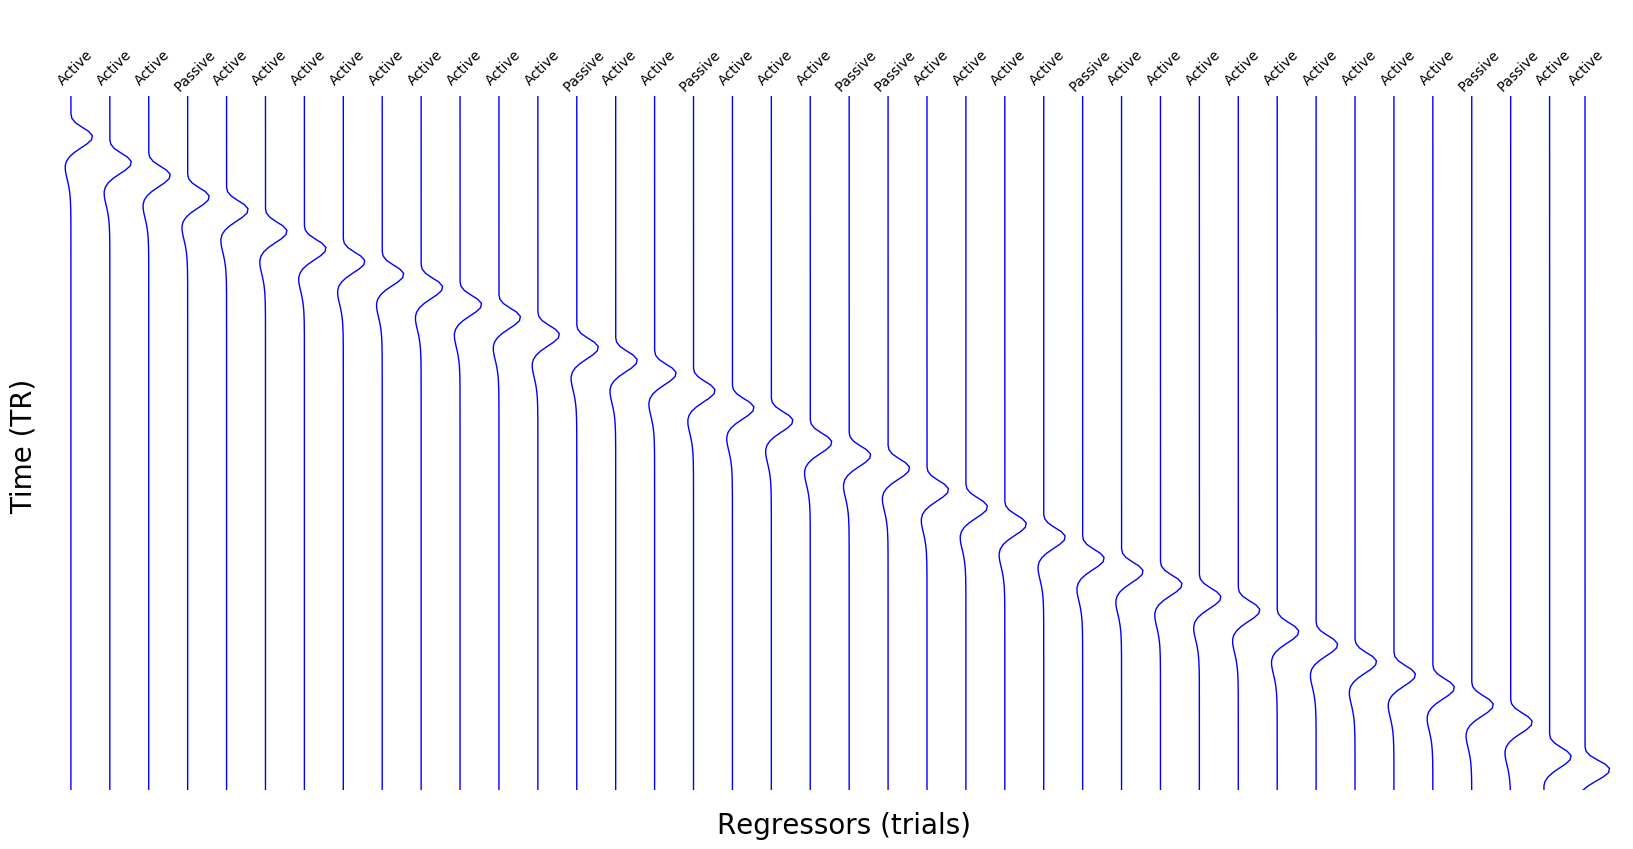

In [6]:
from functions import double_gamma

hrf = double_gamma(range(162))

# List comprehension (fancy for-loop) + stack results back to a matrix
X = np.vstack([np.convolve(hrf, stim_vec[:, i], 'full')[:162] for i in range(40)]).T

plt.figure(figsize=(20, 10))
for plot in range(40):
    plt.subplot(1, 40, plot+1)
    plt.plot(X[:, plot], range(X.shape[0])[::-1])
    plt.axis('off')
    plt.text(-2, 170, 'Active' if onsets[plot, 2] else 'Passive', rotation=45)

plt.text(-80, -10, 'Regressors (trials)', ha='center', fontsize=20)
plt.text(-170, 80, 'Time (TR)', va='center', rotation='vertical', fontsize=20)
plt.show()

As explained in the lecture, we can use this design to extract patterns of $\beta$-values for each regressor. But [it has been shown](http://www.sciencedirect.com/science/article/pii/S1053811910007834) that converting $\beta$-values to t-values often creates more stable and robust patterns. As you might remember from "Neuroimaging: fMRI", $\beta$-values can be normalized to t-values by defining a contrast-against-baseline that is subsequently used in the formula for the t-value. 

Suppose I want to convert the patterns of $\beta$-values *for each trial* in the design above to t-values, how would my contrast-matrix look like? (Hint: check out the first image of this notebook.)

<div class='alert alert-warning'>
**ToDo**: create a design matrix in which each row represents the contrast-against-baseline-vector of a single trial of the within-subject design above. (Hint: check out the `numpy.eye()` function)
</div>

In [7]:
# The numpy.eye function creates an identity-matrix: a matrix with zeros, except on the diagonal
# It takes one argument: the shape of the desired matrix
shape_of_contrast_matrix = onsets.shape[0]
print(np.eye(shape_of_contrast_matrix))

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


So, now you know how to create a "single-trial design" for pattern analyses! As a short summary:
- Model each "trial" (or more generally, "instance") as a separate HRF-convolved regressor;
- Additionally define a contrast-matrix in which each trial is contrasted against baseline in order to create t-value/z-value patterns;

<div class='alert alert-warning'>
**ToDo**: We actually ran the first-level analysis of the single-trial working-memory design outlined above for one subject (sub-0037) using FSL. You can find the results in the directory: `week_1/sub-0037_workingmemory_WITHIN.feat`. Check out the `stats` subdirectory. You will see a number of different types of niftis (pe, cope, varcope, zstat, tstat). Do you remember what each type refers to? (Hint: check out [this link](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT/UserGuide#FEAT_Output).) Also, notice how there are 40 different files of each type, corresponding to the 40 regressors in our single-trial design! 
</div>

ANSWER: Remember the t-value formula? The different files in the `stats` directory simply reflect different parts of the t-value formula, as depicted in the image below:

<img src='tval_formula.png'>

<div class='alert alert-info'>
**ToThink**: in the single-trial designs you've seen so far, we *only* modelled the trials themselves. Now, however, imagine the following experiment: subjects are shown a series of images; an image can be either of condition "A" or of condition "B". Each image is preceded by a cue, which is important to keep the participant focused, but is further irrelevant for the experiment. Suppose you're interested in doing a pattern analysis to show that the patterns of condition "A" images are different than patterns of condition "B" images in superior temporal cortex. Would you include the (onsets of the) cues in the design? If so, why (and how)?
</div>

ANSWER: You would definitely include the cue here, because it probably explains some (task-unrelated) variance! While this will probably not affect your $\beta$-estimates, it will reduce the noise term ($\hat{\sigma}$), and thus lead to higher t-values (i.e. more robust pattern estimates, assuming you will use t-values for your patterns)

Alright, you now know how a single-trial (within-subject) design looks like and what it produces (i.e. single-trial pattern estimates in the form of whole-brain beta/t-stat/z-stat maps). Before we go on to between-subject designs, we are going to load the patterns from one *sample* (in within-subject analyses: one *trial*) in fslview. This will hopefully give you some more "intuition" on what is meant with a single trial pattern. 

<div class='alert alert-warning'>
**ToDo**: open up a new terminal or terminal-tab and start fslview (by typing `fslview` in the terminal). Now, click "File" > "Open", navigate to `week_1/sub-0037_workingmemory_WITHIN.feat/stats` and select `tstat1.nii.gz`. Now, to visualize the patterns somewhat more intuitively, set in the fslview header "Min" to 0 and "Max" to 5. Then, click the little circle with the blue "i": <img src="viz.png">
<br>
Under the "lookup table options", select the "Red-Yellow" colormap. What you visualize here are all the voxels that activate during this particular trial. However, a pattern is not necessarily only the voxels that *activate*, but also those that *deactivate*. A pattern is *any* estimated response of the brain during an instance of a sample (here: a trial). Therefore, let's also visualize the deactivating voxels. To do so, click "File" > "Add" and select the `tstat1.nii.gz` image *again*, but now set "Min" to 0 and "Max" to -5. For this file, select the colormap "Blue-Lightblue". 

What you should see now is something like this: <img src="screenshot_within.png">

<br>
What we visualized here is an example of a within-subject pattern of a particular trial ("sample"), in which the activated voxels (relative to baseline) are colored red/yellow, and the deactivated voxels (relative to baseline) are colored blue/lightblue. Make sure you understand how this image represents the pattern of a single sample.
</div>

### 1.3. Between-subject designs
Between-subject designs are way more 'simple' than within-subject designs. Basically, they're the same as traditional 'activation-based' (univariate) designs in which each condition (*not* trial!) gets its own regressor. Thus, the final design-matrix is, in this case of the WM experiment, only of size 162 x 2 (one 'active' regressor, one 'passive' regressor). This yields then only one beta/t-stat/z-stat image (pattern) per subject. Because subjects represent the samples in between-subject analyses, these 'univariate' designs are applied for multiple subject, whose patterns will make up all the samples in our analysis in the end.

But to reiterate how such a 'univariate' design looks like again (and how it differs from a single-trial within-subject design), we'll create it ourself. 

<div class='alert alert-warning'>
**ToDo**: Below, we again initialized a stimulus-vector matrix with zeros (of shape TRs \* conditions). Now fill it again with ones at times of the stimulus-onsets of each condition.    
</div>

In [8]:
stim_vec_between = np.zeros((162, 2))

# Well extract the index of the trials that are of condition passive ...
passive_idx = onsets[:, 2] == 0
passive_onsets = onsets[passive_idx, 0]

# ... and active
active_idx = onsets[:, 2] == 1
active_onsets = onsets[active_idx, 0]

# And then we'll set the onsets + 2 TRs to one for each condition
stim_vec_between[passive_onsets - 1, 0] = 1
stim_vec_between[passive_onsets, 0] = 1 
stim_vec_between[passive_onsets + 1, 0] = 1

stim_vec_between[active_onsets - 1, 1] = 1
stim_vec_between[active_onsets, 1] = 1 
stim_vec_between[active_onsets + 1, 1] = 1

Now, given that you succesfully filled the stim_vec_between variable with ones, let's plot it again to see how this between-subject design looks like.

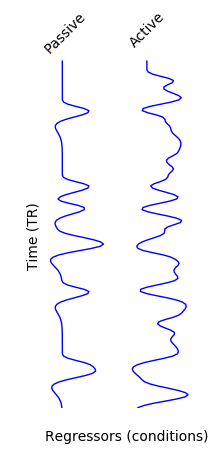

In [9]:
Xb = np.vstack([np.convolve(hrf, stim_vec_between[:, i], 'full')[:162] for i in range(2)]).T

plt.figure(figsize=(2, 5))
for plot in range(2):
    plt.subplot(1, 2, plot+1)
    plt.plot(Xb[:, plot], range(Xb.shape[0])[::-1])
    plt.text(-2, 180, 'Passive' if plot == 0 else 'Active', rotation=45)
    plt.axis('off')
plt.text(-2, -15, 'Regressors (conditions)', ha='center', fontsize=10)
plt.text(-12, 80, 'Time (TR)', va='center', rotation='vertical', fontsize=10)
plt.show()

Normally, you'd evaluate this design using a dedicated neuroimaging software package like FSL. Like the within-subject single trial analysis above, we did this for you already. But, as it pertains to a *between-subject* pattern analysis, we did this for 5 subjects. 

<div class='alert alert-warning'>
**ToDo**: check out the directory `week_1/BETWEEN`. This contains 5 feat-directories, one for each subject. Check out one of the subject-directories and look at the `design.png` file. Make sure, again, that you understand the regressors and the contrasts defined. Now, look at the `reg_standard` directory\*. Make sure you understand why there are (only) three files of each type. What do they correspond to? Lastly, as noted before, in between-subject analyses *each subject represents one instance of a pattern*. In that case, how many instances of patterns (i.e. **samples**) do we have in this between-subject analysis?

<br><br>
\* The `reg_standard` directory contains (the relevant) files from the `stats` directory, but in standard (MNI152 2mm) space instead of "native" (functional) space. Can you think of why you should use patterns in standard space for between-subject analyses? 
</div>

ANSWER: the three files (tstat1, tstat2, tstat3) refer to the different contrast we evaluated (active-baseline, passive-baseline, active-passive). Here, we have 5 samples: each subject represents a sample in between-subject analyses. 

Also, we need MNI-transformed files (i.e. registered to standard space) from the `reg_standard` directory, because we are comparing patterns across subjects! If we would have used native-space patterns, we cannot be sure that voxel `x` from subject 1 is the "same" (i.e. in the same location) as voxel `x` from subject 2. Therefore, if we're doing anything that compares voxels across subjects, we should use data that is registered to a common template.

To visualize, again, the estimated *between-subject* instance of a pattern for a single subject, let's fire up `fslview` again.

<div class='alert alert-warning'>
**ToDo**: click "File" > "Open" and select `week_1/BETWEEN/pi0060/pi0060-piopwm.feat/reg_standard/tstat3.nii.gz`. Set again "Min" to 0 and "Max" to 5, and select the "Red-Yellow" colormap. Now, add the same file again ("File" > "Add"), but set "Min" to 0 and "Max" to -5, and use the "Blue-Lightblue" colormap. What you visualize here, like you did previously with the within-subject pattern estimate of the trial, is the pattern estimate of this *subject*. Given that we used the contrast "active-passive", the pattern here consists of both of voxels that are more active in the active condition than in the passive condition (i.e. the voxels > 0) *and* the voxels that are more active in the passive condition than in the active condition (i.e. the voxels < 0).   
</div>

Hopefully, by creating design matrices for pattern extraction and looking at the results of the pattern-estimation procedure for within- and between-subject pattern analyses in fslview, you understand the differences between these two types better. So far, we demonstrated the main differences between how you would define GLM design matrices to extract beta/t-value patterns for within- and between-subject pattern analyses. Now, we're going to digress slightly (but for a good reason) and talk about object-oriented programming in Python (something you'll encounter a lot in the coming weeks!).

## 2. Object-oriented programming
Python is a so-called `object-oriented` language. What this means is that *everything in Python is some kind of 'object'*, each having it's own *class*. Understanding these concepts is one of the most difficult things in Python (or any other object-oriented language), but it is vital to understand how the language works, and how to use it effectively. Also, in the coming weeks, you use packages (such as [scikit-learn](http://scikit-learn.org)) which strongly rely on Python's object-oriented functionality. 

In this section, we'll walk you through the basics of objects and classes in Python.

N.B.: if you already know about and understand the principles of object-oriented programming, skip this section by all means!

### 2.1.: classes vs. objects
As stated, everything in Python is an object, which is of a certain class. In fact, in the Python tutorial/refresher, you've learned about a couple of different classes already. For example, there is the `string` class:

In [10]:
my_string = 'this is an object of the string-class'
print(type(my_string))

<type 'str'>


As you can see, you check the *class* of any object with the `type()` function. Let's check out some more types.

In [11]:
obj1 = [1, 2, 3]
print(type(obj1))

obj2 = {'entry1': [1, 2, 3], 'entry2': 'testtesttest'}
print(type(obj2))

obj3 = 5
print(type(obj3))

<type 'list'>
<type 'dict'>
<type 'int'>


At this moment, you might be thinking: what is the difference between objects and classes? Well, one way to think about it is to ***think about the relationship between an object and a class as the relationship between a building and it's (architectural) plan.***

In other words, just like a building plan outlines how a building should be constructed, does the class specify how an object should be created\*. Classes in Python define, basically, the attributes (*i.e. things that an object **is/has***) and the methods (*i.e. what each object **can do***).

\* In programmer-lingo, an *object is always an **instance** of a class*.

Remember (from the refresher) the distinction between methods and attributes? Let's look at (some of) the methods and attributes of a numpy-ndarray object:

In [12]:
import numpy as np
my_array = np.array([1, 2, 3, 4])

print('The class of my_array is: %s\n' % type(my_array))

# Let's checkout some attributes
print(my_array.size)
print(my_array.shape)
print(my_array.ndim)

# And some methods ...
print(my_array.reshape((2, 2)))
print(my_array.prod())
print(my_array.mean())

The class of my_array is: <type 'numpy.ndarray'>

4
(4,)
1
[[1 2]
 [3 4]]
24
2.5


As you can see, attributes (like `size`, `shape`, and `ndim`) are things that describe **things that an object has/is/characterizes**, and methods (like `reshape()`, `prod()`, and `mean()`) are **things that an object can do**. 

<div class='alert alert-warning'>
**ToDo**: Below, I imported some object with different types. Figure out the types. Which type has the particular method 'is_integer()'?
</div>

In [13]:
# Check out the types; to which class belongs the method 'is_integer()'?
from functions import return_some_objects
obj1, obj2, obj3 = return_some_objects()

print('Type of obj1 is: %s' % type(obj1))
print('Type of obj2 is: %s' % type(obj2))
print('Type of obj3 is: %s' % type(obj3))

Type of obj1 is: <type 'tuple'>
Type of obj2 is: <type 'bool'>
Type of obj3 is: <type 'float'>


Alright, so let's reiterate what we know so far:

**Classes ("the plan") tell Python how to create objects ("the building"). A major 'responsibility' of classes is to specify which attributes and methods each object has.**

### 2.2: Custom classes
Now, Python (and other modules, like Numpy) have a bunch of built-in classes (like `str`, `list`, `dict`, etc.), but it's also possible to create your own classes! Below, we'll outline how we'd create a custom `Person` class, which has certain attributes and methods. Bear with us, we'll explain how each elements in the class-definition works step-by-step.

In [14]:
class Person():
    """ This `person` class is a (nonsense) example to
    show how classes work. It takes the following parameters
    when initialized:
    
    name : a string
    age : an integer
    """
    
    def __init__(self, name, age):
        self.name = name
        self.age = age
    
    def call_out_my_name(self):
        "This method calls out the name of the Person object. """
        print('My name is %s' % self.name)
        
    def update_age(self, number_to_add):
        """ This method updates the age attribute by a certain number.
        It takes one parameter, `number_to_add` (an integer). """
        self.age = self.age + number_to_add

Alright, so now we defined a custom `Person`-class. As you can see, it looks very similar to when you define a function (but instead of using "`def`" you use the keyword "`class`").

Remember, this is a "plan" (instruction) on how to create ("initialize") an object. Let's do this (i.e. initialize an object of class `Person`).

In [15]:
my_person_object = Person(name='Lukas', age=25)

So, in the code-block above, we initialized a variable (or more specifically: the object) "my_person_object", which is an instance of the class `Person`. The way we initialized this object is how any object in Python is initialized\*:
![alt text](obj_class_diff.png)

\* "Huh, if any object is initialized this way (`obj = Class(inputs)`) then why don't I see that when I initialize builtin Python objects like `strings`, `lists`, `dictionaries`, etc.", you might righfully ask. Very good question, we'll get to that later!

---------------

Now, the `my_person_object` has the methods and attributes that have been specified by the `Person` class! In other words, any method or attribute that you've defined in the class ("the plan") is now *accessible* in the initialized object `my_person_object` ("the building")!

For example, as specified by the class, my_person_object now has the attributes `name` and `age`:

In [16]:
print(my_person_object.name)

Lukas


In [17]:
print(my_person_object.age)

25


And it also has the methods `call_out_my_name()` and `update_age()`:

In [18]:
my_person_object.call_out_my_name()

My name is Lukas


In [19]:
number_to_update_age_with = 10
my_person_object.update_age(number_to_update_age_with)

<div class='alert alert-warning'>
**ToDo**: create a new instance of the `Person` class (e.g. with your own name and age) and mess around with it a little bit (e.g. call the update_age() function a couple of times and see how the age-attribute changes). 
</div>

In [20]:
# Mess around with a new Person instance


So, alright, when we instantiated the my_person_object object according to the Person class, somehow the class "bound" the attributes and methods to the object. 

*But how on earth does the class do that?*

#### 2.2.1: the \_\_init\_\_ method
If you look at the class definition of `Person` above, you might recognize functions (started by the keyword `def`) inside the class, like `__init__()` and `call_out_my_name()`. These are methods! Just remember: any `def` *inside* a class is a method (as explained in the refresher, methods are just functions applied to objects themselves). 

Let's talk about the `__init__()` method, a daunting but necessary element of each (custom) class. While it looks complicated (with all the underscores everywhere), it does just one simple thing: **it binds attributes to the object it*self***. 

Basically, when you initialize an object (e.g. by `Person(name='some name', age=42)`), Python will secretly call the `__init__()` method. By convention, the first argument to `__init__()` is *always* "self". What "self" represents, is a bit tricky to understand, but try to see it like this: 

**"self" functions as a placeholder/template in the class, that will be 'filled in' by the specific object once it is initialized.**

Alright, complicated stuff. Let's try to clarify this statement by looking at another (simpler) example:

In [21]:
class Computer():
    # os = operating system
    def __init__(self, os, owner):
        
        self.os = os
        self.owner = owner
        
        # As a side-note, you don't have to give the attribute the same name as 
        # the parameter. For example, you could also do this:
        #
        # self.my_operating_system_whatevs = os
        #
        # However, it is customary to use the same name as the parameter for clarity

In [22]:
computer_object = Computer(os='Windows', owner='Noor')

Remember, a class is nothing more than an **instruction** ("plan") on how to create an object. As such, what you see in the Computer class definition, is an "instruction" that specifies that the attributes `os` and `owner` should be bound to the "placeholder" *self*. Once we *actually* initialize an object (as we did in the code cell above by `Computer(os='Windows', owner='Noor')`), the attributes ('Windows' and 'Noor') are not bound to the template *self* but to the actual `computer_object` object! That's why we can now access the `os` attribute from the `computer_object` itself:

In [23]:
print(computer_object.os)

Windows


Thus, "self" only functions as a placeholder in the class (the "plan"/"instruction"), which is replaced by the actual object upon initialization.

Importantly, each argument that is listed in the `__init__()` method (here: `os` and `owner`) should be "filled in" when initializing a Computer object. Thus, for example, the following crashes because it expects and `owner` argument, but it hasn't received it during initialization:

In [24]:
another_computer = Computer(os='Linux')

TypeError: __init__() takes exactly 3 arguments (2 given)

<div class='alert alert-info'>
**ToThink**: In the error message above, you see that `__init__()` is called when we tried to initialize a Computer-object, just as we expected! But the error also says that it takes 3 argument, but only received 2. This might seem weird, since we only passed *one* argument (namely `os`='Linux'), but this in fact makes sense. Why?
</div>

ANSWER: Because it always implicitly passes the argument *self* to \_\_init\_\_! So even if a Class (or method!) does not need any arguments explicitly, it always passes **one** argument, namely *self*. 

Alright, let's reiterate what we know of the `__init__()` method and its relation to classes so far:

1. It binds attributes to the object itself;
2. It always takes *self* as a first argument;
3. *self* functions as a "template" for when an object is actually initialized;
4. Any argument that is listed in the `__init__()` method will be expected upon initialization;
5. Any attribute or method defined in the class will be accessible after initialization

#### 2.1.2: other methods 
As discussed earlier, each function definition (recognizable by the `def` keyword) in a class refers to a method. Let's look at the `Person` class example again (copy-pasted from earlier in the document):

In [25]:
class Person():
    """ This `person` class is a (nonsense) example to
    show how classes work. It takes the following parameters
    when constructed:
    
    name : a string
    age : an integer
    """
    
    def __init__(self, name, age):
        self.name = name
        self.age = age
    
    def call_out_my_name(self):
        "This method calls out the name of the Person object. """
        print('My name is %s' % self.name)
        
    def update_age(self, number_to_add):
        """ This method updates the age attribute by a certain number.
        It takes one parameter, `number_to_add` (an integer). """
        self.age = self.age + number_to_add

As we can see, apart from the `__init__()` method, there are two other methods: `call_out_my_name()` and `update_age()`. Like the `__init__()` method, they always expect *self* as the first argument. By always passing *self* to methods, we can access and use the attributes of the object. For example, the `call_out_my_name()` function accesses and uses the `name` attribute.

Apart from *self*, methods can also take additional "non-self" arguments. This you see for example in the `update_age()` method: as any method, it takes *self* as the first argument, but also needs an additional argument - `number_to_add`. 

Thus, methods can use "internal arguments" (the class attributes) and "external arguments" (which you have to provide when you call the method).

Then, inside the `update_age()` method, another interesting thing happens. We're actually modifying the `age` attribute. Whut?

Let's look at what that entails:

In [26]:
personx = Person('Noor', 24) # Note that, like functions, you don't *need* to provide keywords, like name='Noor'
print("This person, named %s, is %i years old" % (personx.name, personx.age))

# Let's now update Noor's age (let's assume that it's 20-04, Noor's birthday)
personx.update_age(number_to_add=1)
print("This person is now %i years old!" % personx.age)

This person, named Noor, is 24 years old
This person is now 25 years old!


Note that because the `update_age()` method only modifies its own attributes, you don't need a `return` statement for the effect to take place. This construct of modifying internal attributes and thus omitting a return statement is also known as "in-place modifications". You can, however, both change (or even add) internal attributes *and* return things, like the following (more realistic) example shows:

In [27]:
import nibabel as nib

class Niftiloader():
    # Tip: it is customary in Python to start custom classes with a capital letter!
    
    def __init__(self, path_to_nifti):
        # Here, we bind the argument path_to_nifti to self
        self.path_to_nifti = path_to_nifti
        
    def load_and_return_shape(self):
        
        nifti_file = nib.load(self.path_to_nifti)
        self.loaded_data = nifti_file.get_data()
        
        nifti_shape = nifti_file.shape
        
        return nifti_shape

The NiftiLoader class has a method `load_and_return_shape()` that both adds an attribute (namely `loaded_data`) *and* returns, additionally, the shape of the nifti-file (i.e. the voxel dimensions)! Let's first initialize a Niftiloader object and check which attributes it has after initialization.

In [29]:
example_nifti = 'sub-0037_workingmemory_WITHIN.feat/stats/tstat1.nii.gz'

# Here we initialize a Niftiloader object
my_loader = Niftiloader(path_to_nifti=example_nifti)

# path_to_nifti attribute exists!
print(my_loader.path_to_nifti)

# ... but loaded_data attributes doesn't (yet) ...
print(my_loader.loaded_data)

sub-0037_workingmemory_WITHIN.feat/stats/tstat1.nii.gz


AttributeError: Niftiloader instance has no attribute 'loaded_data'

But if we call the `load_and_return_shape()` function (and return the loaded data!), suddenly the `loaded_data` attribute *does* exist!

In [30]:
# We call the method load_and_return_shape() here
nif_shape = my_loader.load_and_return_shape()
print(my_loader.loaded_data)

# Also, we stored the shape that is returned from the load_and_return_shape() method into another variable ('nif_shape'),
print('\nThe shape of my nifti is: %s' % (nif_shape,))

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  

<div class='alert alert-warning'>
**ToDo**: time to practice! We copy-pasted the `Niftiloader` class below, and we'd like you to extend the class as follows: add a method (named `calculate_min_and_max()`) that only takes *self* as an input argument and gets both the minimum value and maximum value from the `loaded_data` attribute. Then, it should create two new attributes (`min` and `max`, which should contain these values). Lastly, it should also explicitly **return** the extracted min and max value as a single tuple.
</div>

In [31]:
import nibabel as nib

class Niftiloader():
    
    def __init__(self, path_to_nifti):
        
        self.path_to_nifti = path_to_nifti
        
    def load_and_return_shape(self):
        
        nifti_file = nib.load(self.path_to_nifti)
        self.loaded_data = nifti_file.get_data()
        
        nifti_shape = nifti_file.shape
        
        return nifti_shape
    
    # Add the new method here!
    def calculate_min_and_max(self):
        self.max = self.loaded_data.max()
        self.min = self.loaded_data.min()
        out = (self.max, self.min)
        return out      

In [32]:
# You can test your new Niftiloader object here!
# It should not give any errors
niftiloader_new = Niftiloader(path_to_nifti=example_nifti)

# First call load_and_return_shape() to load in the data
shape = niftiloader_new.load_and_return_shape()

# And now we'll call your calculate_min_and_max() method!
out = niftiloader_new.calculate_min_and_max()

# Let's test if everything ran as expected
# (We use the 'assert' statement to check if the ouput of the 
#  statement all return to True; if not, you made an error somewhere!)

# Check if the 'min' and 'max' attributes exist!
assert(all(hasattr(niftiloader_new, att) for att in ['min', 'max']))

# Check if the return values are indeed a tuple of length 2
assert(isinstance(out, tuple) and len(out) == 2)

### 2.3: classes in builtin Python objects
Remember that we told you that "everything in Python is an object"? And that each object is initialized according to a class, which takes the format: `obj = Someclass(args)`? You might have noticed that this format is not *always* used, most prominently in built-in Python classes, like `list`, `dict`, `string`, etc. 

Let's look at an example. We can initialize a list seemingly without a class:

In [33]:
my_list_object = [1, 2, 3]
print(type(my_list_object))

<type 'list'>


In fact, what happened was that actually the `[]` functions as a "shortcut" for the class definition of a list! In fact, you can also just do:

In [34]:
# just use the class definition list(input)
my_list_object = list([1, 2, 3])
my_list_object_with_brackets = [1, 2, 3]

# Is it really the same?
print(my_list_object == my_list_object_with_brackets)

True


So, using [] to initialize a list is just a shortcut for the class definition `list()`. In fact, this is true for many builtin Python objects. "Why?", you ask? Well, it's simply because programmers are lazy beings. Builtin types (like list, string, dict, etc.) are used so often that they invented (even) shorter "shortcuts" to initialize those objects. 

Other "shortcuts" for builtin types are:

In [35]:
# To initialize a string
str('my string') # the same as 'my string'
dict(key1=[1, 2, 3], key2=[5, 2, 1]) # the same as {'key1': [1, 2, 3], 'key2': [5, 2, 1]}
tuple((1, 2, 3)) # the same as (1, 2, 3)

(1, 2, 3)

Alright, that should be enough to understand the object-oriented programming concepts we're going to encounter in the rest of this course! Now, we are going to work with some real (pattern-based) fMRI data and store it in a custom object!

But not after a short assignment!

<div class='alert alert-danger'>
**Assignment 1** (3 points): write a custom class, named `NiftiExplorer`, that is initialized with one parameter: `path_to_nifti` (referring to a string pointing to the path of a 4D nifti file). Then, write three methods: the first one - `load_data()` should read in the Nifti-file (using nibabel) and create a new attribute: `data` (which should be the loaded data as a 4D numpy array). The second method, named `demean_data()`, should subtract the temporal mean from each voxel in the `data` attribute and store the result in the `data` attribute again (effectively "updating" it). A third method, named `plot_histogram_of_values()`. This method should take the `data` attribute and make a histogram of all its **non-zero** values using matplotlib (google how to do this if you forgot!). The method should take one parameter, `bins`, that is used in the matplotlib histogram function to control the number of bins. Hint: set the default range in the histogram to (-500, 500).
</div>

In [36]:
# This makes sure that you plot inside the notebook
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# implement your class here!
class NiftiExplorer():
    
    def __init__(self, path_to_nifti):
        
        self.path_to_nifti = path_to_nifti
    
    def load_data(self):
        
        self.data = nib.load(self.path_to_nifti).get_data()
        
    def demean_data(self):
        # axis=3 means the last index, i.e. the time-axis
        # N.B.: numpy broadcasting (i.e. subtract a 3D array from a 4D array)
        # only works when there is a singleton dimension, like: (80, 80, 37, 1).
        # The mean function "squeezes" out this singleton dimension by default,
        # but if you set keepdims to True, this dimension isn't squeezed out, which
        # we need for the broadcasting operation! (h/t to Timo)
        # My bad for not telling you guys this!
        
        self.data = self.data - self.data.mean(axis=3, keepdims=True)
    
        # Alternative to the keepdims thingie, you could also manually
        # add another singleton axis for broadcasting by np.newaxis
        self.data = self.data - self.data.mean(axis=3)[:, :, :, np.newaxis]
    
    def plot_histogram_of_values(self, bins):
        nonzero_idx = self.data != 0 
        nonzerodata = self.data[nonzero_idx]
        plt.hist(nonzerodata, bins=bins, range=(-500, 500))
        plt.show()

NiftiExplorer object is correctly initialized!
The load_data() method works correctly!
The demean_data() method works correctly!


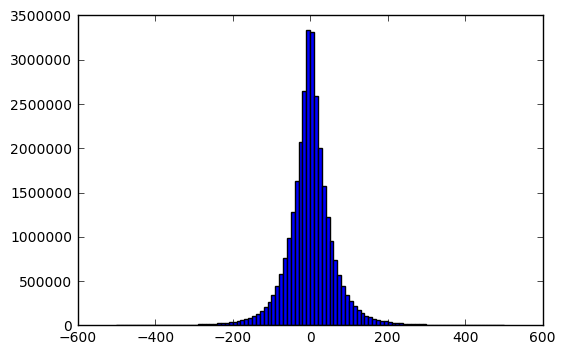

The plot_histogram_of_values() method works correctly!


In [53]:
# You can run this code-block to see whether everything runs as expected
# If there are no errors, you did everything correctly!

nifti_path = 'filtered_func_data.nii.gz'
nifex = NiftiExplorer(nifti_path)

# check if it bound the param path_to_nifti to self
assert(hasattr(nifex, 'path_to_nifti'))

print('NiftiExplorer object is correctly initialized!')

nifex.load_data()

# Check if you created the attribute data
assert(hasattr(nifex, 'data'))

# and if it's indeed a numpy array
assert(isinstance(nifex.data, np.ndarray))

print('The load_data() method works correctly!')

# Run demean_data
nifex.demean_data()

# quick-and-dirty way to test if every voxel's temporal mean is approx. 0
np.testing.assert_almost_equal(nifex.data.mean(axis=3), 0, decimal=1)

print('The demean_data() method works correctly!')

# Check if plotting method works!
nifex.plot_histogram_of_values(bins=100)

print('The plot_histogram_of_values() method works correctly!')

## 3: Data representation
In pattern analyses, there is a specific way to 'store' and represent brain patterns: as 2D matrices of shape N-samples \* N-voxels. **Important**: often (and confusingly), people refer to voxels as (brain) 'features' in pattern analyses. So in articles people often refer to samples-by-features matrices!

Anyway, this is how such a matrix looks like: 
![](data_representation.png)

Each row thus represents the voxel pattern of a sample (or: "instance")!

<div class='alert alert-info'>
**ToThink**: samples are defined differently for within- and between-subject designs, as discussed in the previous section. What constitutes (typically) a sample in between-subject designs? And in within-subject designs?
</div>

ANSWER:

Between-subject: subjects

Within-subject: "trials"


As you can see, the originally 3D voxel patterns (e.g. whole-brain patterns of t-values) are flattened (also called "vectorized" or "raveled") such that we can stack all patterns vertically into a 2D matrix. There are two reasons why pattern analyses need this 2D format and thus discard spatial information about the voxel patterns:
 
1. There are very few analyses that take spatial information into account in the first place (so by flattening we get rid of the spatial information); 
2. Most algorithms used "under the hood" by pattern analyses rely heavily on matrix algebra (which operate on 2D matrices by definition).

Anyway, let's look at an example. We're going to work with the working-memory data (as outline in the beginning of the notebook). Suppose we want to investigate whether we can predict whether a trial is passive or active (factor: working memory load) from (whole-brain) voxel patterns. Consequently, this is a **within-subject design**. As such, we model each trial separately by fitting a single-trial design matrix to obtain patterns of t-values per trial (similar to the plot just before section **1.3**). The results are in the directory: `sub-0037_workingmemory_WITHIN.feat`. Check out the directory (again) and especially the stats-folder. You should see a bunch of nifti-files which contain 3D voxel patterns with either "pe" (parameter estimates, FSLs way of referring to $\beta$s), "cope", "varcope", "zstat", or "tstat" values.

For this analysis, we're going to use patterns of t-stats (as is generally recommended over $\beta$s).<br>
As you can see, there are 40 nifti-files with t-stats; these refer to the 40 trials in the experiment (32 active trials, 8 passive trials)! Given that we need to adhere to the data representation as outlined above, we are in the following situation:

**What we have**: 40 (3D) nifti-files<br>
**What we need**: one 2D numpy array of shape 40 x {whatever amount of voxels there are in those niftis}

Alright, time to learn some Python gems that help us load in and transform those patterns into a usable 2D numpy matrix.

### 3.1: tips & tricks to load and transform (nifti-)files
As a first thing, we need to find all the paths to the tstat nifti-files. Python has a nifty (pun intended) tool called "`glob`" which can find files/directories on disk using [wildcards](https://en.wikipedia.org/wiki/Wildcard_character). It is usually imported as follows:

In [54]:
from glob import glob

`glob`, in Python, is a function that takes a path (as a string) with one or more wildcard characters (such as the `*`) and searches for files/directories on disk that match that. For example, let's try to find all the png-images in the current directory using glob (these are the images that I used inside this notebook). 

In [55]:
my_search_string = '*.png'
png_files = glob(my_search_string)
print(png_files)

['WM_example.png', 'data_representation.png', 'tval_formula.png', 'screenshot_within.png', 'obj_class_diff.png', 'viz.png', 'single_trial_design.png', 'within_subject_example.png']


As you can see, it returns a list with all the files/directories that matched the search-string. Note that you can also search files outside of the current directory (note that we're in the directory `/home/nipa_?/week_1` right now). To do so, we can simply specify the relative or absolute path to it. For example, suppose I would like to find all the home-directories of the students of this course. I could simply do:

In [56]:
all_student_home_dirs = glob('/home/nipa_*')
print(all_student_home_dirs)

[]


<div class='alert alert-warning'>
**ToDo**: Now you have the skills to actually "glob" all the t-stats yourself! Use glob to find all the paths to the t-stats and store the results (a list with 40 strings) in a variable called `tstat_paths`.
</div>

In [57]:
# Implement the ToDo here!
tstat_paths = glob('sub-0037_workingmemory_WITHIN.feat/stats/tstat*.nii.gz')

**Warning**: `glob` returns unsorted paths (so in seemingly random order). It's better if we sort the paths before loading them in, so the order of the paths is more intuitive (the first file is tstat1, the seconds tstat2, etc.). Python has a builtin function `sorted()`, which takes a list and sorts it alphabetically. The problem, here, is that if we'd use that - i.e. `sorted(tstat_paths)` - it will actually sort the files as: tstat1, tstat10, tstat11, etc. See for yourself: 

In [58]:
print(sorted(tstat_paths))

['sub-0037_workingmemory_WITHIN.feat/stats/tstat1.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat10.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat11.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat12.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat13.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat14.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat15.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat16.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat17.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat18.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat19.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat2.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat20.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat21.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat22.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat23.nii.gz', 'sub-0037_workingmemory_WITHIN.feat/stats/tstat24.nii.gz'

To fix this issue, we wrote a little function (`sort_nifti_paths()`) that sorts the paths correctly. (If you're interested in how it works, check out the functions.py file in the week_1 directory.)

In [59]:
# Let's fix it
from functions import sort_nifti_paths
tstat_paths = sort_nifti_paths(tstat_paths)

<div class='alert alert-warning'>
**ToDo**: in the code block below, write a loop that loads in the tstat nifti-files one by one (using nibabel) and store them in the already preallocated array "X". Note that "X" is a 2D matrix (samples-by-features), but each tstat-file contains a 3D array, so you need to "flatten" the 3D array to a single vector: use e.g. the numpy function "flatten()" or "ravel()". 
</div>

In [60]:
voxel_dims = (80, 80, 37)
X = np.zeros((len(tstat_paths), np.prod(voxel_dims)))

# Start your loop here!
for i in range(len(tstat_paths)):
    data_tmp = nib.load(tstat_paths[i]).get_data()
    X[i, :] = data_tmp.ravel() 

<div class='alert alert-warning'>
**ToDo**: You just globbed and loaded the within-subject patterns into a 2D samples-by-features data matrix, awesome! Now, do the same thing for the between-subject patterns (in the `BETWEEN/*.feat` directories). Use the patterns from the `act-pas` contrast (tstat3/zstat3) **from the reg_standard** directory. Glob the files and load them in using a similar for-loop as above!
</div>

In [62]:
# We already defined the samples-by-features matrix for you
voxel_dims = (91, 109, 91) # MNI152 2mm x/y/z voxel dimensions
Xbetween = np.zeros((5, np.prod(voxel_dims)))

# Glob the files here and then loop over them to fill the Xbetween matrix
files_between = glob('BETWEEN/*.feat/reg_standard/tstat3.nii.gz')
for i in range(5):
    
    Xbetween[i, :] = nib.load(files_between[i]).get_data().ravel()

If you managed to do the two ToDos (wow, that's a horrible sentence), then you've managed to do one of the most important things in pattern analyses: getting the data (patterns) in the right format: a 2D matrix of samples-by-(brain-)features. As you've seen, "samples" refer to "trials" (i.e. any instance of your feature-of-interest) in within-subject analyses while samples refer subjects in between-subject analyses. The (brain-)features represent single-trial contrasts against baseline in within-subject analyses and a 'condition-average' contrast against baseline (e.g. active > baseline) or against another condition (e.g. active > passive) in between-subject analyses.

From here onwards, we will learn how to apply pattern analyses to data in this format, which is (in a way) *much* easier because we will use mostly existing packages (like [scikit-learn](http://scikit-learn.org) for decoding analyses). When you use the right tools, you can literally implement a pattern analysis is 30 lines of code. But that's for the next two weeks.

For the final assignment of this week, you are going to create a custom class `Mvp` (which stands for **M**ulti**v**oxel **p**attern) that sort of "organizes" the loading process, data representation, and contains some methods that act upon (e.g. preprocess) the 2D samples-by-feature matrix. In the next weeks, you'll extend this Mvp-class with more functionality as you'll learn new things (e.g we'll add some decoding-related methods in week 2 and some RSA-related methods in week 3). 

<div class='alert alert-danger'>
**Assignment 2** (7 points). Create a new class, `Mvp`, that takes as input a list of paths to nifti-files that represent the samples in a given pattern analysis. This class should contain three methods:<br><br>
1. a method `load()` that loads the nifti-files (which are by now an attribute) using a loop similar to the last ToDo; the resulting samples-by-features matrix should be bound to self as a new attribute "`X`";<br><br>
2. another method, `standardize()`, that standardizes each feature (voxel) in the 2D `data` attribute. Standardization is a common "preprocessing step" in pattern analyses that ensures that feature (columns in the 2D matrix) has mean 0 and standard deviation 1 (more info [here](https://en.wikipedia.org/wiki/Feature_scaling#Standardization)). Essentially, you just subtract each column's mean from each value in the column and then divide each value in the column by the standard deviation in the column;<br><br>
3. a method `apply_mask()`, that takes two parameters, `path_to_mask`, which should be a nifti-file containing a mask (e.g. a mask of the amygdala), and `threshold`, a number that should indicate the minimum value that a voxel in the mask should take to be included in the mask. This method should first load in the mask (using nibabel), then make a boolean array of the mask (array with True for voxels above the threshold, False for those below) and ravel (flatten) the result in a 1D vector, and finally use this boolean mask-array to index and update the columns of the `X` attribute such that afterwards it only contains voxels specified in the thresholded mask. <br><br>

**Hints**:<br><br>
1. Test your code! You can use the tstat_paths we "globbed" earlier from the `sub-0037_WITHIN.feat` directory; <br><br>
2. The methods do not need to return anything: everything is applied to the internal attributes (mostly the `X` attribute); <br><br>
3. We supplied a probabilistic amygdala mask for you (`sub-0037_workingmemory_WITHIN.feat/Left_Amygdala_mask_epi.nii.gz`) to test your `apply_mask()` method with. If your method works correctly, your `X` attribute should be of shape [40, 280] after applying the mask *with a threshold of 0* to it.<br><br>
</div>

In [63]:
# Define your class here!
class Mvp():
    
    def __init__(self, paths):
        
        self.paths = paths
        
    def load(self):
        
        voxel_dims = (80, 80, 37)
        X = np.zeros((len(self.paths), np.prod(voxel_dims)))

        # Start your loop here!
        for i, path in enumerate(self.paths):
    
            X[i, :] = nib.load(path).get_data().ravel()
        
        self.X = X
    
    def standardize(self):
        # this implements (x - x_mean) / x_std
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        
    def apply_mask(self, path_to_mask, threshold):
        
        mask = nib.load(path_to_mask).get_data()
        mask_bool = mask > threshold
        self.X = self.X[:, mask_bool.ravel()]

In [64]:
# Run this block to test your class! If there are no errors, it's correct!

# Filter the annoying divide-by-zero runtime error
import warnings
warnings.filterwarnings('ignore')

# We use the tstat_paths from earlier
mvp = Mvp(tstat_paths)

# Load the tstats 
mvp.load()

# Check if the mvp has an attribute 'X'
assert(hasattr(mvp, 'X'))

# Check if 'X' is a numpy array
assert(isinstance(mvp.X, np.ndarray))

# Check if 'X' has the right samples-by-features shape
assert(mvp.X.shape == (40, 80*80*37))

print('The load() method is correct!')

# This produces some NaNs (because we might divide by 0 for voxels outside the brain),
# but that's fine
mvp.standardize()

# Check if all columns (i.e. features) have approx. mean 0 and std 1
np.testing.assert_almost_equal(np.nansum(mvp.X.mean(axis=0)), 0)

# calculate all non-NaN stds ...
stds = np.nanstd(mvp.X, axis=0)[np.invert(np.isnan(np.nanstd(mvp.X, axis=0)))]

# ... and check whether they're all 1 (by checking the sum)
np.testing.assert_almost_equal(np.sum(stds), len(stds))

print('The standardize() method is correct!')

mvp.apply_mask('sub-0037_workingmemory_WITHIN.feat/Left_Amygdala_mask_epi.nii.gz', threshold=0)

assert(mvp.X.shape == (40, 280))

print('The apply_mask() method is correct!')

The load() method is correct!
The standardize() method is correct!
The apply_mask() method is correct!
